In [1]:
from lavis.datasets.builders import load_dataset
from lavis.models import load_model_and_preprocess
from dotenv import load_dotenv
from PIL import Image
from algo import (
    PITOME,
    TOME,
    DIFFRATE,
    DCT,
    TOFU,
    LTMP,
    NONE, 
    pitome,
    tome,
    DiffRate,
    tofu,
    # ltmp
)

FLICKR_PATH='/media/caduser/MyBook/chau/.cache/flickr30k/images'
model, vis_processors, txt_processors = load_model_and_preprocess("blip_retrieval", "coco", is_eval=False)
dataset = load_dataset("flickr30k", vis_path=FLICKR_PATH, cfg_path=None)


Using downloaded and verified file: /media/caduser/MyBook/chau/.cache/flickr30k/annotations/train.json
Using downloaded and verified file: /media/caduser/MyBook/chau/.cache/flickr30k/annotations/val.json
Using downloaded and verified file: /media/caduser/MyBook/chau/.cache/flickr30k/annotations/test.json


In [2]:
dataset

{'train': <lavis.datasets.datasets.retrieval_datasets.RetrievalDataset at 0x7f944ea4b890>,
 'val': <lavis.datasets.datasets.retrieval_datasets.RetrievalEvalDataset at 0x7f93a4509ad0>,
 'test': <lavis.datasets.datasets.retrieval_datasets.RetrievalEvalDataset at 0x7f92c06cf690>}

In [3]:

from lavis.processors.base_processor import BaseProcessor
from lavis.processors.randaugment import RandomAugment
from omegaconf import OmegaConf
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from lavis.processors.blip_processors import BlipImageBaseProcessor

img = dataset['train'][0]['image']
img_input = vis_processors['eval'](img)
# img 

In [18]:
from main_vl import (
    PITOME,
    TOME, 
    TOFU, 
    DIFFRATE, 
)

def get_model(model, algo, ratio):
    if algo == PITOME:
        pitome.patch.blip(model.visual_encoder,use_k=False, trace_source=True)
        pitome.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True)
        model.visual_encoder.ratio=ratio
        model.visual_encoder_m.ratio=ratio
    elif algo == TOME:
        tome.patch.blip(model.visual_encoder,use_k=False, trace_source=True)
        tome.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True)
        model.visual_encoder.ratio=ratio
        model.visual_encoder_m.ratio=ratio
    elif algo == TOFU:
        tofu.patch.blip(model.visual_encoder,use_k=False, trace_source=True)
        tofu.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True)
        model.visual_encoder.ratio=ratio
        model.visual_encoder_m.ratio=ratio
    elif algo == DIFFRATE:
        DiffRate.patch.blip(model.visual_encoder,use_k=False, trace_source=True)
        DiffRate.patch.blip(model.visual_encoder_m,use_k=False, trace_source=True)
        model.visual_encoder.init_kept_num_using_ratio(ratio)
        model.visual_encoder_m.init_kept_num_using_ratio(ratio)


get_model(model,PITOME, 0.9)

model 

using pitome
using pitome


BlipRetrieval(
  (visual_encoder): PiToMeVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x PiToMeBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=Fa

In [20]:
class BlipImageEvalProcessor(BlipImageBaseProcessor):
    def __init__(self, image_size=384, mean=None, std=None):
        super().__init__(mean=mean, std=std)

      
        transform_list = [
            transforms.Resize(
                (image_size, image_size), interpolation=InterpolationMode.BICUBIC
            ),
        ]

        # The visualization and model need different transforms
        self.transform_vis  = transforms.Compose(transform_list)
        self.transform = transforms.Compose(transform_list + [
            transforms.ToTensor(),
            self.normalize,
        ])

    def __call__(self, item):
        return self.transform_vis(item), self.transform(item)

    @classmethod
    def from_config(cls, cfg=None):
        if cfg is None:
            cfg = OmegaConf.create()

        image_size = cfg.get("image_size", 384)

        mean = cfg.get("mean", None)
        std = cfg.get("std", None)

        return cls(image_size=image_size, mean=mean, std=std)

processor = BlipImageEvalProcessor() 
img_vis, img_input = processor(img)

model.visual_encoder(img_input[None,...])

tensor([[[ 1.1561,  0.3989, -0.6911,  ..., -0.7228, -0.7252, -0.6876],
         [-0.0675, -0.3633, -0.4782,  ...,  0.3754,  0.4632, -0.8394],
         [ 0.2254, -0.2778,  0.3667,  ..., -0.3522, -0.1329, -0.4285],
         ...,
         [ 0.1090, -0.5618, -0.5600,  ...,  0.4161, -0.3511, -0.5478],
         [ 0.4815, -0.8285, -0.4550,  ...,  0.2384, -0.6939, -0.6153],
         [-0.7430,  0.0312,  0.2361,  ..., -1.4236,  0.0519, -0.5049]]],
       grad_fn=<NativeLayerNormBackward0>)

tensor([[[1., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
num_group 166
vis torch.Size([1, 576])
mask torch.Size([1, 1, 24, 24])
color (3,)
mask edge (384, 384, 1)


/media/caduser/MyBook/DATA/vit_token_compress/PiToMe/algo/pitome/vis.py:68: RuntimeWarning: invalid value encountered in divide
  color = (mask * img).sum(axis=(0, 1)) / mask.sum()


vis torch.Size([1, 576])
mask torch.Size([1, 1, 24, 24])
color (3,)
mask edge (384, 384, 1)
vis torch.Size([1, 576])
mask torch.Size([1, 1, 24, 24])
color (3,)
mask edge (384, 384, 1)
vis torch.Size([1, 576])
mask torch.Size([1, 1, 24, 24])
color (3,)
mask edge (384, 384, 1)
vis torch.Size([1, 576])
mask torch.Size([1, 1, 24, 24])
color (3,)
mask edge (384, 384, 1)
vis torch.Size([1, 576])
mask torch.Size([1, 1, 24, 24])
color (3,)
mask edge (384, 384, 1)
vis torch.Size([1, 576])
mask torch.Size([1, 1, 24, 24])
color (3,)
mask edge (384, 384, 1)
vis torch.Size([1, 576])
mask torch.Size([1, 1, 24, 24])
color (3,)
mask edge (384, 384, 1)
vis torch.Size([1, 576])
mask torch.Size([1, 1, 24, 24])
color (3,)
mask edge (384, 384, 1)
vis torch.Size([1, 576])
mask torch.Size([1, 1, 24, 24])
color (3,)
mask edge (384, 384, 1)
vis torch.Size([1, 576])
mask torch.Size([1, 1, 24, 24])
color (3,)
mask edge (384, 384, 1)
vis torch.Size([1, 576])
mask torch.Size([1, 1, 24, 24])
color (3,)
mask edge (3

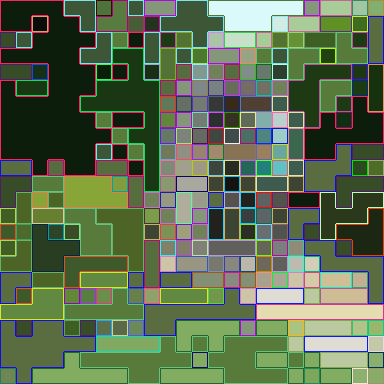

In [22]:
source = model.visual_encoder._tome_info['source']

print(source)
pitome.make_visualization(img_vis, source, patch_size=16, class_token=True)